## Домашняя работа по базовой математической статистике для Data scientist

Задания со зведочкой не обязательны для зачета.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats


df = pd.read_csv("bikeshare.csv")
del df['datetime']

# Есть ощущение, что такие метрики как season, holiday, workingday и weather
# нам не особо-то интересны в данном контексте, т.к. они:
# 1. слишком дискретны (малое множество возможных значений)
# 2. сами по себе они бесполезны и нужно их рассматривать в связке с другими 
#    параметрами (когда будем смотреть корреляции)
# 3. для них мы и так примерно понимаем распределение, никакой новой информации
#    они не несут
# 4. ... и графики распределение некрасивые получаются
useless_metrics = ["season", "workingday", "holiday", "weather"]
usefull_mterics = list(set(df.columns) - set(useless_metrics))

df.head(10)

['registered', 'windspeed', 'count', 'casual', 'humidity', 'temp', 'atemp']


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


### 1.
Постройте гистограмму распределения каждой из метрик в датасете при помощи метода датафрейма `hist()`. При необходимости добавьте логарифмированную ось (параметр log).

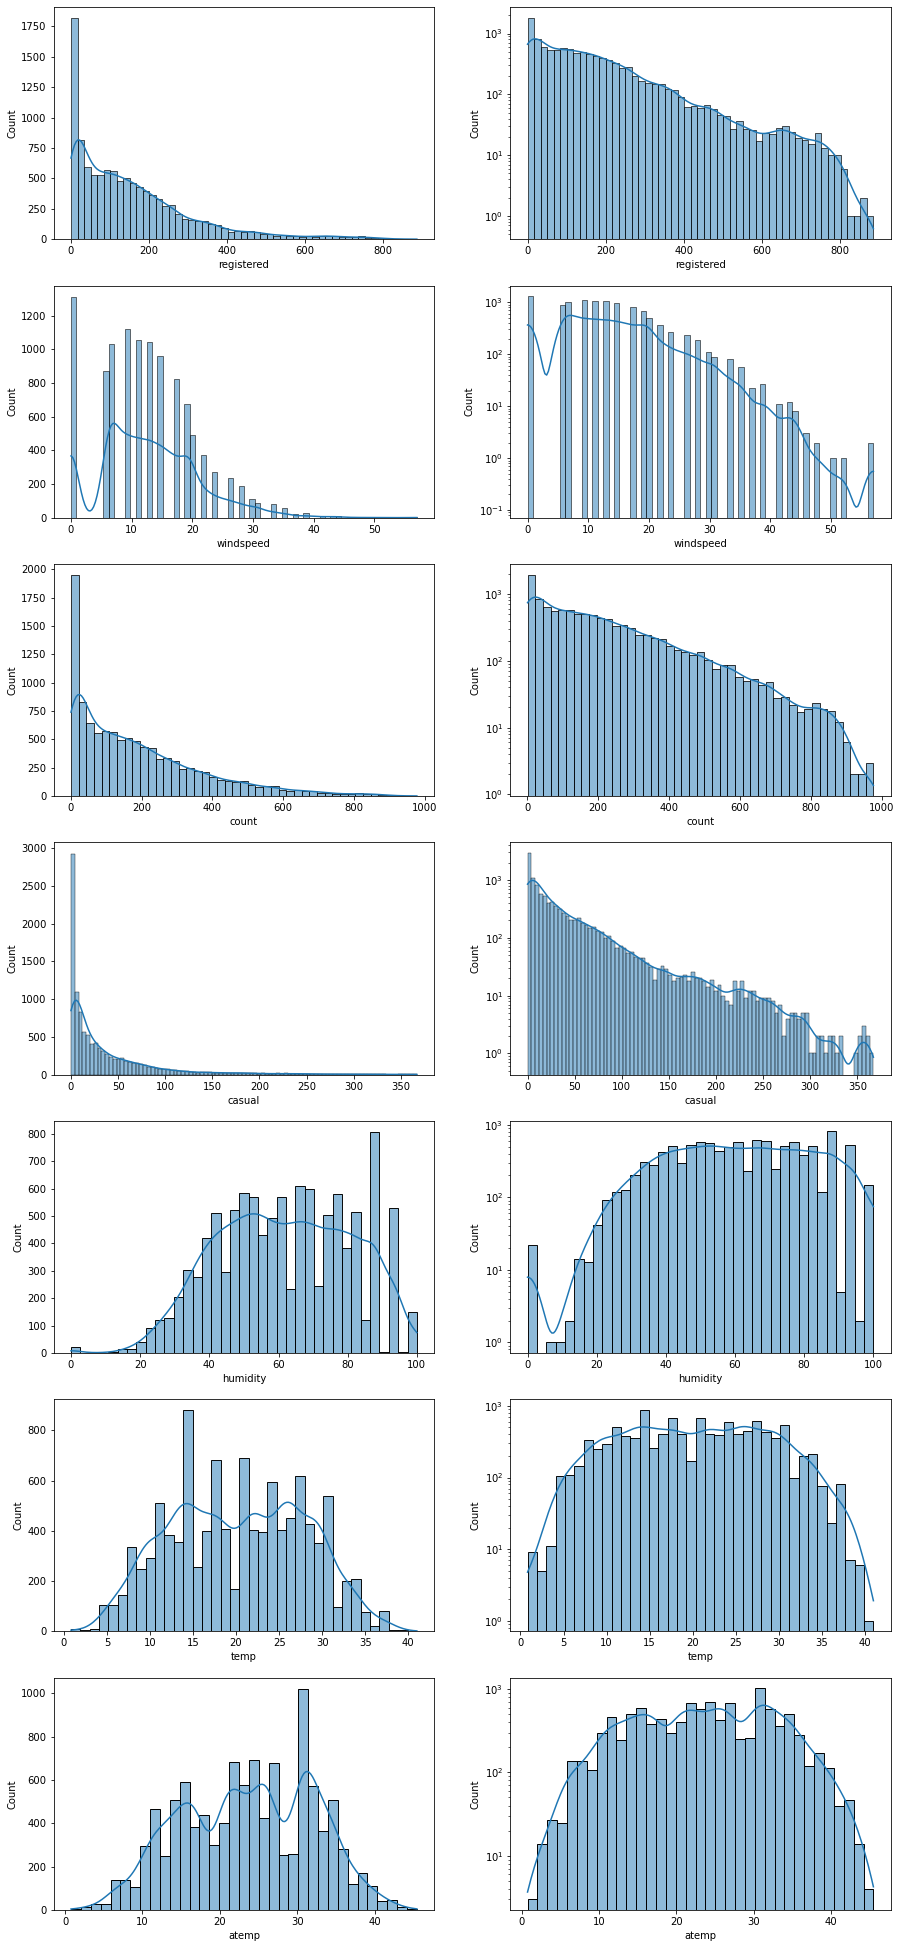

In [9]:
### YOUR CODE HERE ###

total = len(usefull_mterics)
fix, plots = plt.subplots(total, 2, figsize=(15, total * 5), sharey=False)
for idx, column in enumerate(usefull_mterics):
    #df.hist(column, ax=plots[idx])  # seaborn histplot looks much better
    sns.histplot(df[column], ax=plots[idx, 0], kde=True)
    sns.histplot(df[column], ax=plots[idx, 1], log_scale=(None, 10), kde=True)
    
plt.show()

### 2.
Для каждой метрики найдите среднее, дисперсию, 50, 75 и 99 перцентили, моду. Какие выводы о наличии аномалий мы можем сделать?

In [37]:
describes = [df[column].describe(percentiles=[0.5, 0.75, 0.99]) for column in usefull_mterics]

df_stat = pd.DataFrame(
    data={
        "mean": [desc.loc["mean"] for desc in describes],
        "mod": df[usefull_mterics].mode().iloc[0].tolist(),
        "std": [desc.loc["std"] for desc in describes],
        "50%": [desc.loc["50%"] for desc in describes],
        "75%": [desc.loc["75%"] for desc in describes],
        "99%": [desc.loc["99%"] for desc in describes],},
    index=usefull_mterics
)

df_stat

,mean,mod,std,50%,75%,99%
registered,155.552177,3.00,151.039033,118.000,222.0000,697.0000
windspeed,12.799395,0.00,8.164537,12.998,16.9979,35.0008
count,191.574132,5.00,181.144454,145.000,284.0000,774.1500
casual,36.021955,0.00,49.960477,17.000,49.0000,240.1500
humidity,61.886460,88.00,19.245033,62.000,77.0000,100.0000
temp,20.230860,14.76,7.791590,20.500,26.2400,36.0800
atemp,23.655084,31.06,8.474601,24.240,31.0600,40.1500


**Выводы:**
метрики *registered*, *count* и *casual* демонстрируют большую разницу между средним значением и модой, что может свидетельствовать об ассиметричности распределения 

### 3. (*) 
 Для каждой метрики проанализируйте ассиметрию и смещенность распределения – для этого посчитайте для каждой метрики коэффициент ассиметрии и эксцесса.

In [54]:
df_stat["kurtosis"] = [kurtosis(df[column]) for column in usefull_mterics]
df_stat["skew"] = [skew(df[column]) for column in usefull_mterics]

df_stat[["kurtosis", "skew"]]

,kurtosis,skew
registered,2.624324,1.524594
windspeed,0.629292,0.588685
count,1.298945,1.241895
casual,7.547610,2.495404
humidity,-0.760020,-0.086323
temp,-0.914661,0.003690
atemp,-0.850236,-0.102545


### 4.

Постройте симметричный доверительный интервал для метрики с самой большой дисперсией при доверительной вероятности 0.95. 

In [55]:
# Я в замешательстве: разве плотность вероятности для метрики не должна 
# соответствовать нормальному распределению? Даже визуально плотность
# вероятности для метрики 'count' (с наибольшей дисперсией) не похожа
# на гауссиану и мне кажется неправильным использовать для построения
# доверительного интервала функцию 'stats.norm.interval', которая ожидает
# что метрика имеет распределение близкое к нормальному.

max_std = df_stat["std"].max()
metric = df_stat[df_stat["std"] == max_std].iloc[0]
interval = stats.norm.interval(0.95, metric["mean"], metric["std"])
interval


(-163.46247359398893, 546.6107374190854)

### 5. (*)

Найдите количество значений, выходящих за три сигмы для каждой из метрик. Где получилось больше всего аномалий?

In [56]:
def count_anomalies(column):
    mean = df_stat.loc[column]["mean"]
    std = df_stat.loc[column]["std"]
    return (np.abs(df[column] - mean) > 3 * std).sum()

df_stat["anomalies"] = [count_anomalies(column) for column in usefull_mterics]
df_stat[["anomalies"]]

,anomalies
registered,235
windspeed,67
count,147
casual,292
humidity,22
temp,0
atemp,0


### 6.

Постройте корреляционную матрицу и heatmap по метрикам. Какие выводы о наличии связей можно сделать?

<AxesSubplot:>

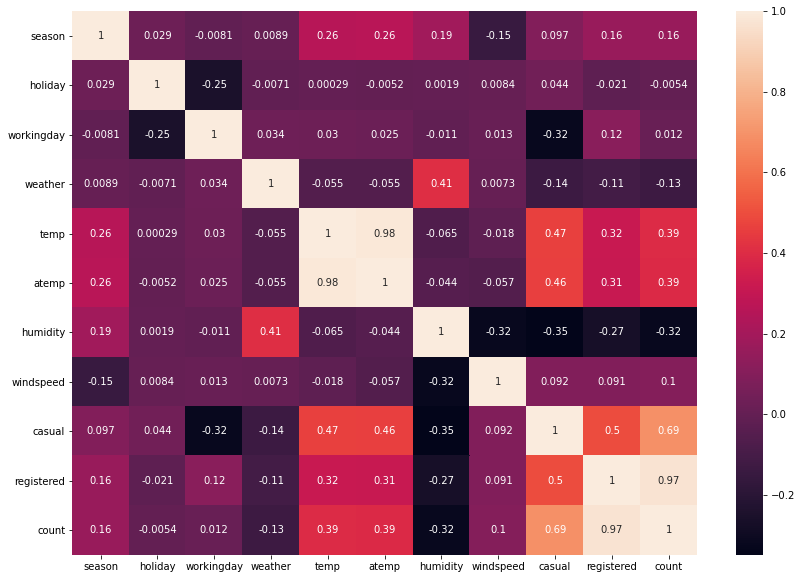

In [63]:
# Здесь можем использовать не только лишь usefull_metrics, а все метрики
correlations = df.corr()
plt.figure(figsize=(14,10))
sns.heatmap(correlations, annot=True)

**Выводы:**
Пержде всего, должен отметить, что я не нашёл никакой информации о том, что эито за датасет и могу лишь догадываться о значении его столбцов. Хорошо бы добавить эту информацию в описании домашнего задания.

Видна заметная и высокая взаимная корреляция между трему параметрами: *count*, *registered* и *casual*. Но я полагаю, что эти метрики и так связаны между собой очевидным образом (как количество зарегистрированных и количество выполненных заказов) и эта корреляция америки не откроет.

Я ожидал увидеть корреляцию между 'count' и метриками 'season'/'holiday'/'weather', однако здесь её нет. Скорее всего потому, что это ранговые данные и корреляцию для них нужно строить иначе, но как это делать в данном модуле не рассматривалось.

Ещё есть заметная корреляция между 'temp'/'atemp' и 'casual'/'count'.
И есть слабая орицательная коллеряция между 'humidity' и 'casual'